In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
data_dir = './data'
exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='wm')
erp = decode_eeg.ERP(exp)

In [4]:
xdata_all, ydata_all = erp.load_all_eeg(xdata_var_name = 'wm_xdata', ydata_var_name = 'wm_ydata')

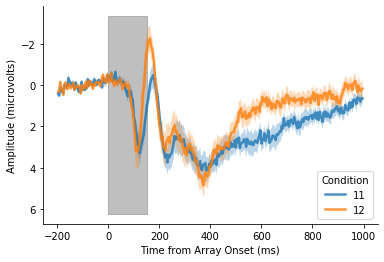

In [32]:
erp.plot_conditions(xdata_all,ydata_all,electrode_subset = ('O','P'),conditions = [11,12])

In [87]:
time_window = 30
time_step = 30
trial_average = 10
n_splits = 30
group_dict = {0:[21],1:[22],2:[24],3:[28]}
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=4)

In [88]:
for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub,xdata_var_name='wm_xdata',ydata_var_name='wm_ydata')
    xdata,ydata = wrangl.setup_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [89]:
interp = decode_eeg.Interpreter(clfr)

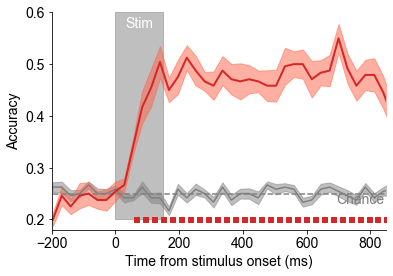

In [91]:
interp.plot_acc(significance_testing=1,savefig=0,ylim=[.18,.6])

Saving output\figures\conf_mat20201113_2027.pdf
Saving output\figures\conf_mat20201113_2027.png


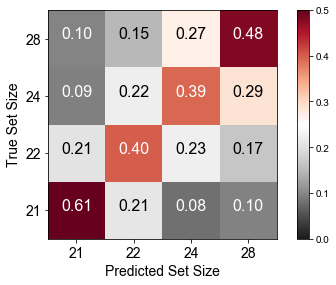

In [94]:
interp.plot_conf_mat(lower=.0,upper=.5,savefig=1)